Using **Diamonds** sample datasets, we will implement **Entity Embedding for Categorical Variables** and validate the effect on the evaluation.

In [138]:
import os
import gc
import pickle
import numpy as np; np.random.seed(42)
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold

from tensorflow import set_random_seed; set_random_seed(42)

# from keras.models import Model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout, Activation, Merge
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
diamonds = sns.load_dataset("diamonds")

print(diamonds.shape)
diamonds.head()

(53940, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Base Model (XGBoost)

In [84]:
diamonds = sns.load_dataset("diamonds")

def feature_engineering(data):
    for col in data.columns:
        if type(data[col].iloc[0]) == str:
            le = LabelEncoder()
            data[col] = le.fit_transform(np.array(data[col]))
    return data


diamonds = feature_engineering(diamonds)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [85]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

params = {
          "objective": "reg:linear",
          "eval_metric": "mae",
          "nthread": 4,
          "learning_rate": 0.05,
          "min_child_weight": 0,
          "max_depth": 8,
          "gamma": 0,
          "subsample":0.9,
          "colsample_bytree": 0.9,
          "reg_lambda": 0,
          "silent": 1,
          "seed": 42
         }

def MAPE(trues, preds):
    return np.mean(np.absolute(trues - preds)/trues)

def modeling_xgb(data, params):
    ## Prepare for Xgboost
    #Split dataset to train and test data: Hold-Out
    X_train, X_test, y_train, y_test = train_test_split(data.drop(["price", "x", "y", "z"], axis=1), data["price"], test_size=0.2, random_state = 42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)
    print("学習データ数: {}, 検証データ数: {}, テストデータ数: {}".format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))
    print("X_train: {}\ny_train:{}".format(X_train.iloc[0], y_train.iloc[0]))
    #Get labels
    feature_names = np.array(X_train.columns)
    #Change data-type to matrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.tolist(), feature_names = feature_names)
    dvalid = xgb.DMatrix(X_valid.values, label=y_valid.tolist(), feature_names = feature_names)
    dtest = xgb.DMatrix(X_test.values, label=y_test.tolist(), feature_names = feature_names)
    
    print("process training..")
    model = xgb.train(params, dtrain, num_boost_round=4000, evals=[(dtrain, 'train'), (dvalid, 'eval')], early_stopping_rounds=100, verbose_eval=100)
    
    print("process evaluation...")
    pred_valid = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    
    MAE_valid = mean_absolute_error(y_valid, pred_valid)
    MAE_test = mean_absolute_error(y_test, pred_test)
    MAPE_valid = MAPE(y_valid, pred_valid)
    MAPE_test = MAPE(y_test, pred_test)
    
    #結果出力用
    df_valid = pd.DataFrame(data = {
        "y_valid": y_valid,
        "pred_valid": pred_valid
    })
    df_test = pd.DataFrame(data = {
        "y_test": y_test,
        "pred_test": pred_test
    })
    
    print("MAE_valid：{}  ".format(round(MAE_valid)) )
    print("MAE_test：{}  ".format(round(MAE_test)) )
    print("MAPE_valid：{}  ".format(round(MAPE_valid,4)) )
    print("MAPE_test：{}  ".format(round(MAPE_test,4)) )
    
    return df_valid, df_test

df_valid_xgb, df_test_xgb = modeling_xgb(diamonds, params)

学習データ数: 34521, 検証データ数: 8631, テストデータ数: 10788
X_train: carat       1.16
cut         1.00
color       2.00
clarity     3.00
depth      60.80
table      65.00
Name: 6881, dtype: float64
y_train:4131
process training..
[0]	train-mae:3754.57	eval-mae:3691.36
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[100]	train-mae:278.045	eval-mae:304.577
[200]	train-mae:231.23	eval-mae:277.039
[300]	train-mae:219.739	eval-mae:275.447
[400]	train-mae:208.701	eval-mae:274.647
[500]	train-mae:195.299	eval-mae:274.452
[600]	train-mae:184.048	eval-mae:274.962
Stopping. Best iteration:
[512]	train-mae:194.268	eval-mae:274.224

process evaluation...
MAE_valid：274.0  
MAE_test：273.0  
MAPE_valid：0.0786  
MAPE_test：0.0787  
CPU times: user 11.2 s, sys: 1.05 s, total: 12.2 s
Wall time: 5.87 s


## Base Model (NN)

In [147]:
%%time
diamonds = sns.load_dataset("diamonds")

def csv2dicts(df):
    data = []
    keys = []
    for i in range(len(diamonds)):
        if i == 0:
            keys = diamonds.columns.tolist()
            print("columns:", keys)
        if i % 10000 == 0:
            print(i, "/", len(diamonds))
        arr = diamonds.iloc[i]
        data.append({key: value for key, value in zip(keys, arr)})
    return data

def set_nan_as_string(data, replace_str='0'):
    for i, x in enumerate(data):
        for key, value in x.items():
            if value == '':
                x[key] = replace_str
        data[i] = x
    return data
        
data = csv2dicts(diamonds)
print(data[0])



def feature_list(record, features):
    fl=[]
    for feature in features:
        fl += [record[feature]]
    return fl

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def prepare_features(data, features):
    train_X = []
    train_y = []
    for record in data:
        fl = feature_list(record, features)
        train_X += [fl]
        train_y += [int(float(record["price"]))]
    print("Number of train datapoints: ", len(train_y))
    print("train_y MIN:", min(train_y), "train_y MAX:", max(train_y))
    train_X = pd.DataFrame(np.array(train_X), columns=features).astype({"carat":float, "depth":float, "table":float})
    train_X, new_columns = one_hot_encoder(train_X)
    new_features = train_X.columns.tolist()
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    print(train_X[0], train_y[0])
    return train_X, train_y, new_features
    
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table']
X, y, features = prepare_features(data, features)

columns: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
0 / 53940
10000 / 53940
20000 / 53940
30000 / 53940
40000 / 53940
50000 / 53940
{'carat': 0.23, 'cut': 'Ideal', 'color': 'E', 'clarity': 'SI2', 'depth': 61.5, 'table': 55.0, 'price': 326, 'x': 3.95, 'y': 3.98, 'z': 2.43}
Number of train datapoints:  53940
train_y MIN: 326 train_y MAX: 18823
[ 0.23 61.5  55.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.  ] 326
CPU times: user 9.75 s, sys: 148 ms, total: 9.89 s
Wall time: 10.8 s


## NN with Entity Embedding

In [149]:
%%time
diamonds = sns.load_dataset("diamonds")

def csv2dicts(df):
    data = []
    keys = []
    for i in range(len(diamonds)):
        if i == 0:
            keys = diamonds.columns.tolist()
            print("columns:", keys)
        if i % 10000 == 0:
            print(i, "/", len(diamonds))
        arr = diamonds.iloc[i]
        data.append({key: value for key, value in zip(keys, arr)})
    return data

def set_nan_as_string(data, replace_str='0'):
    for i, x in enumerate(data):
        for key, value in x.items():
            if value == '':
                x[key] = replace_str
        data[i] = x
        
        
data = csv2dicts(diamonds)
print(data[0])

columns: ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
0 / 53940
10000 / 53940
20000 / 53940
30000 / 53940
40000 / 53940
50000 / 53940
{'carat': 0.23, 'cut': 'Ideal', 'color': 'E', 'clarity': 'SI2', 'depth': 61.5, 'table': 55.0, 'price': 326, 'x': 3.95, 'y': 3.98, 'z': 2.43}
CPU times: user 9.74 s, sys: 136 ms, total: 9.87 s
Wall time: 10.9 s


In [150]:
def feature_list(record, features):
    fl=[]
    for feature in features:
        fl += [record[feature]]
    return fl

def prepare_features(data, features):
    train_X = []
    train_y = []
    for record in data:
        fl = feature_list(record, features)
        train_X += [fl]
        train_y += [int(float(record["price"]))]
    print("Number of train datapoints: ", len(train_y))
    print("train_y MIN:", min(train_y), "train_y MAX:", max(train_y))
    
    train_X = np.array(train_X)
    full_X = train_X.copy()
    scalers = []
    les = []
    for i in range(train_X.shape[1]):
        try: 
            float(full_X[0, i][0])
#             scaler = StandardScaler()
#             scaler.fit(full_X[:, i].reshape(-1, 1))
#             train_X[:, i] = scaler.transform(train_X[:, i].reshape(1,-1))
#             train_X[:, i] = np.array(train_X[:, i])
#             scaler = StandardScaler()
#             scalers.append(scaler.fit(full_X[:, i].reshape(-1, 1)))
        except:
            print(features[i], "is encoded")
            le = LabelEncoder()
            le.fit(full_X[:, i])
            train_X[:, i] = le.transform(train_X[:, i])
            les.append(le.fit_transform(full_X[:, i]))

    train_X = train_X.astype(float)
#     train_X = train_X.astype(int)
    train_y = np.array(train_y)
    print(train_X[0], train_y[0])
    
    return train_X, train_y, les, scalers
    
    
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table']
X, y, les, scalers = prepare_features(data, features)

Number of train datapoints:  53940
train_y MIN: 326 train_y MAX: 18823
cut is encoded
color is encoded
clarity is encoded
[ 0.23  2.    1.    3.   61.5  55.  ] 326


In [151]:
def split_features(X):
    X_list = []

    carat = X[..., [0]]
    X_list.append(carat)

    cut = X[..., [1]]
    X_list.append(cut)

    color = X[..., [2]]
    X_list.append(color)

    clarity = X[..., [3]]
    X_list.append(clarity)

    depth = X[..., [4]]
    X_list.append(depth)

    table = X[..., [5]]
    X_list.append(table)

    return X_list

class Model(object):

    def evaluate(self, X_val, y_val):
        assert(min(y_val) > 0)
        guessed_sales = self.guess(X_val)
        relative_err = np.absolute((y_val - guessed_sales) / y_val)
        result = np.sum(relative_err) / len(y_val)
        return result

class NN_with_EntityEmbedding(Model):

    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.epochs = 1000
        self.batch_size = 128
        self.checkpointer = ModelCheckpoint(filepath="best_model_weights.hdf5", verbose=1, save_best_only=True)
        self.early_stopping = EarlyStopping(monitor='mean_absolute_error', patience=20, verbose=0, mode='auto')
        self.max_log_y = max(np.max(np.log(y_train)), np.max(np.log(y_val)))
        self.__build_keras_model()
        self.fit(X_train, y_train, X_val, y_val)

    def preprocessing(self, X):
        X_list = split_features(X)
        return X_list
    
    def Embedding_inOut(self, input_len, output_len, layer_name):
        input_col = Input(shape=(1,))
        output_col = Embedding(input_len, output_len, name=layer_name)(input_col)
        output_col = Reshape(target_shape=(output_len,))(output_col)
        return input_col, output_col
    
    def Dense_inOut(self, output_len, layer_name):
        input_col = Input(shape=(1,))
        output_col = Dense(output_len)(input_col)
        return input_col, output_col

    def __build_keras_model(self):
        input_carat, output_carat = self.Dense_inOut(1, "carat_embedding")  # 274
        input_cut, output_cut = self.Embedding_inOut(5, 4, "cut_embedding")
        input_color, output_color = self.Embedding_inOut(7, 6, "color_embedding")
        input_clarity, output_clarity = self.Embedding_inOut(8, 7, "clarity_embedding")
        input_depth, output_depth = self.Dense_inOut(1, "depth_embedding")  # 184
        input_table, output_table = self.Dense_inOut(1, "table_embedding")  # 128

        input_model = [input_carat, input_cut, input_color, input_clarity, input_depth, input_table]
        output_embeddings = [output_carat, output_cut, output_color, output_clarity, output_depth, output_table]

        output_model = Concatenate()(output_embeddings)
        output_model = Dense(512, kernel_initializer="he_normal")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dropout(0.2)(output_model)
        output_model = BatchNormalization()(output_model)
        output_model = Dense(128, kernel_initializer="he_normal")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dropout(0.2)(output_model)
        output_model = BatchNormalization()(output_model)
        output_model = Dense(1)(output_model)
        # output_model = Activation('sigmoid')(output_model)

        self.model = KerasModel(inputs=input_model, outputs=output_model)

        self.model.compile(loss='mean_absolute_error', optimizer='adam')

    def _val_for_fit(self, val):
        val = np.log(val) / self.max_log_y
        return val

    def _val_for_pred(self, val):
        return np.exp(val * self.max_log_y)

    def fit(self, X_train, y_train, X_val, y_val):
        self.model.fit(self.preprocessing(X_train), self._val_for_fit(y_train),
                       validation_data=(self.preprocessing(X_val), self._val_for_fit(y_val)),
                       epochs=self.epochs, batch_size=self.batch_size,
                       callbacks=[self.early_stopping],
                       # callbacks=[self.checkpointer],
                       )
        # self.model.load_weights('best_model_weights.hdf5')
        print("Result on validation data: ", self.evaluate(X_val, y_val))

    def guess(self, features):
        features = self.preprocessing(features)
        result = self.model.predict(features).flatten()
        return self._val_for_pred(result)

In [ ]:
# %%time
def model(X, y):
    train_ratio = 0.8
    shuffle_data = True
    one_hot_as_input = False
    embeddings_as_input = False
    save_embeddings = True
    saved_embeddings_fname = "embeddings.pickle"  # set save_embeddings to True to create this file
    
    num_records = len(X)
    train_size = int(train_ratio * num_records)
    
    if shuffle_data:
        print("Using shuffled data")
        sh = np.arange(X.shape[0])
        np.random.seed(seed=42)
        np.random.shuffle(sh)
        X = X[sh]
        y = y[sh]
        print(sh)

    if embeddings_as_input:
        print("Using learned embeddings as input")
        X = embed_features(X, saved_embeddings_fname)

    if one_hot_as_input:
        print("Using one-hot encoding as input")
        enc = OneHotEncoder(sparse=False)
        enc.fit(X)
        X = enc.transform(X)
    
    X_train = X[:train_size]
    X_val = X[train_size:]
    y_train = y[:train_size]
    y_val = y[train_size:]
    
    print("Number of samples used for training: " + str(y_train.shape[0]))
    
    print("Fitting NN_with_EntityEmbedding...")
    models = []
    iter_N = 1
    for i in range(iter_N):
        print("iteration: {}/{}".format(i+1, iter_N))
        models.append(NN_with_EntityEmbedding(X_train, y_train, X_val, y_val))
    
    if save_embeddings:
        model = models[0].model
#         carat_embedding = model.get_layer('carat_embedding').get_weights()[0]
        cut_embedding = model.get_layer('cut_embedding').get_weights()[0]
        color_embedding = model.get_layer('color_embedding').get_weights()[0]
        clarity_embedding = model.get_layer('clarity_embedding').get_weights()[0]
#         depth_embedding = model.get_layer('depth_embedding').get_weights()[0]
#         table_embedding = model.get_layer('table_embedding').get_weights()[0]
        
#         list_embedding = [carat_embedding, cut_embedding, color_embedding, clarity_embedding, depth_embedding, table_embedding]
        list_embedding = [cut_embedding, color_embedding, clarity_embedding]
        with open(saved_embeddings_fname, 'wb') as f:
            pickle.dump(list_embedding, f, -1)
            
    def evaluate_models(models, X, y):
        assert(min(y) > 0)
        guessed_y = np.array([model.guess(X) for model in models])
        mean_y = guessed_y.mean(axis=0)
        relative_err = np.absolute((y - mean_y) / y)
        result = np.sum(relative_err) / len(y)
        return result, y, mean_y
    
    print("Evaluate combined models...")
    print("Training error...")
    train_score, train_y, train_pred = evaluate_models(models, X_train, y_train)
    print(train_score)

    print("Validation error...")
    val_score, val_y, val_pred = evaluate_models(models, X_val, y_val)
    print(val_score)
    
    return train_y, train_pred, val_y, val_pred, list_embedding
    

train_y, train_pred, val_y, val_pred, list_embedding = model(X, y)
df_test_nn = pd.DataFrame({"val_y": val_y, "val_pred": val_pred})

Using shuffled data
[ 1388 50052 41645 ... 38158   860 15795]
Number of samples used for training: 43152
Fitting NN_with_EntityEmbedding...
iteration: 1/1
Train on 43152 samples, validate on 10788 samples
Epoch 1/1000
43152/43152 [==============================] - 10s 231us/step - loss: 0.4294 - val_loss: 0.2543
Epoch 2/1000
 2176/43152 [>.............................] - ETA: 3s - loss: 0.1449

/Users/ishikawa1225/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/callbacks.py:497: RuntimeWarning: Early stopping conditioned on metric `mean_absolute_error` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


43152/43152 [==============================] - 3s 81us/step - loss: 0.0855 - val_loss: 0.0212
Epoch 3/1000
43152/43152 [==============================] - 3s 79us/step - loss: 0.0365 - val_loss: 0.0156
Epoch 4/1000
43152/43152 [==============================] - 3s 77us/step - loss: 0.0276 - val_loss: 0.0290
Epoch 5/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0256 - val_loss: 0.0121
Epoch 6/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0235 - val_loss: 0.0112
Epoch 7/1000
43152/43152 [==============================] - 3s 76us/step - loss: 0.0223 - val_loss: 0.0135
Epoch 8/1000
43152/43152 [==============================] - 4s 86us/step - loss: 0.0217 - val_loss: 0.0135
Epoch 9/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0210 - val_loss: 0.0149
Epoch 10/1000
43152/43152 [==============================] - 3s 78us/step - loss: 0.0204 - val_loss: 0.0131
Epoch 11/1000
43152/43152 [======================

43152/43152 [==============================] - 3s 80us/step - loss: 0.0141 - val_loss: 0.0091
Epoch 79/1000
43152/43152 [==============================] - 3s 75us/step - loss: 0.0136 - val_loss: 0.0111
Epoch 80/1000
43152/43152 [==============================] - 3s 79us/step - loss: 0.0142 - val_loss: 0.0093
Epoch 81/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0138 - val_loss: 0.0092
Epoch 82/1000
43152/43152 [==============================] - 3s 75us/step - loss: 0.0139 - val_loss: 0.0094
Epoch 83/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0139 - val_loss: 0.0107
Epoch 84/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0140 - val_loss: 0.0115
Epoch 85/1000
43152/43152 [==============================] - 3s 75us/step - loss: 0.0137 - val_loss: 0.0088
Epoch 86/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0141 - val_loss: 0.0098
Epoch 87/1000
43152/43152 [===============

43152/43152 [==============================] - 3s 74us/step - loss: 0.0134 - val_loss: 0.0083
Epoch 154/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0129 - val_loss: 0.0102
Epoch 155/1000
43152/43152 [==============================] - 3s 79us/step - loss: 0.0132 - val_loss: 0.0080
Epoch 156/1000
43152/43152 [==============================] - 3s 73us/step - loss: 0.0134 - val_loss: 0.0114
Epoch 157/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0133 - val_loss: 0.0080
Epoch 158/1000
43152/43152 [==============================] - 3s 79us/step - loss: 0.0135 - val_loss: 0.0110
Epoch 159/1000
43152/43152 [==============================] - 3s 77us/step - loss: 0.0137 - val_loss: 0.0086
Epoch 160/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0132 - val_loss: 0.0081
Epoch 161/1000
43152/43152 [==============================] - 3s 77us/step - loss: 0.0133 - val_loss: 0.0095
Epoch 162/1000
43152/43152 [======

43152/43152 [==============================] - 3s 73us/step - loss: 0.0136 - val_loss: 0.0087
Epoch 229/1000
43152/43152 [==============================] - 3s 76us/step - loss: 0.0133 - val_loss: 0.0082
Epoch 230/1000
43152/43152 [==============================] - 4s 81us/step - loss: 0.0134 - val_loss: 0.0107
Epoch 231/1000
43152/43152 [==============================] - 3s 72us/step - loss: 0.0137 - val_loss: 0.0106
Epoch 232/1000
43152/43152 [==============================] - 4s 81us/step - loss: 0.0130 - val_loss: 0.0103
Epoch 233/1000
43152/43152 [==============================] - 3s 77us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 234/1000
43152/43152 [==============================] - 3s 74us/step - loss: 0.0134 - val_loss: 0.0089
Epoch 235/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0131 - val_loss: 0.0093
Epoch 236/1000
43152/43152 [==============================] - 3s 78us/step - loss: 0.0133 - val_loss: 0.0101
Epoch 237/1000
43152/43152 [======

43152/43152 [==============================] - 3s 80us/step - loss: 0.0132 - val_loss: 0.0080
Epoch 304/1000
43152/43152 [==============================] - 3s 80us/step - loss: 0.0133 - val_loss: 0.0107
Epoch 305/1000
43152/43152 [==============================] - 3s 76us/step - loss: 0.0132 - val_loss: 0.0112
Epoch 306/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0128 - val_loss: 0.0085
Epoch 307/1000
43152/43152 [==============================] - 3s 77us/step - loss: 0.0133 - val_loss: 0.0085
Epoch 308/1000
43152/43152 [==============================] - 3s 76us/step - loss: 0.0132 - val_loss: 0.0111
Epoch 309/1000
43152/43152 [==============================] - 4s 83us/step - loss: 0.0131 - val_loss: 0.0108
Epoch 310/1000
43152/43152 [==============================] - 3s 76us/step - loss: 0.0137 - val_loss: 0.0081
Epoch 311/1000
43152/43152 [==============================] - 3s 76us/step - loss: 0.0137 - val_loss: 0.0080
Epoch 312/1000
43152/43152 [======

43152/43152 [==============================] - 4s 84us/step - loss: 0.0135 - val_loss: 0.0088
Epoch 379/1000
43152/43152 [==============================] - 3s 76us/step - loss: 0.0132 - val_loss: 0.0091
Epoch 380/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0133 - val_loss: 0.0107
Epoch 381/1000
43152/43152 [==============================] - 4s 83us/step - loss: 0.0133 - val_loss: 0.0078
Epoch 382/1000
43152/43152 [==============================] - 3s 81us/step - loss: 0.0133 - val_loss: 0.0087
Epoch 383/1000
43152/43152 [==============================] - 3s 78us/step - loss: 0.0133 - val_loss: 0.0091
Epoch 384/1000
43152/43152 [==============================] - 4s 95us/step - loss: 0.0135 - val_loss: 0.0082
Epoch 385/1000
43152/43152 [==============================] - 4s 82us/step - loss: 0.0135 - val_loss: 0.0097
Epoch 386/1000
43152/43152 [==============================] - 3s 69us/step - loss: 0.0133 - val_loss: 0.0103
Epoch 387/1000
43152/43152 [======

In [144]:
# epoch=1000 + EarlyStopping=20, batch_size=128, 512->128, dropout=0.2, Embed&Dense, Dense:1->1
# loss: 0.0136 - val_loss: 0.0094
# Result on validation data:  0.08924037141486463
print( MAPE(val_y, val_pred) )
print(mean_absolute_error(val_y, val_pred))

0.1045076024041152
520.5193616352923


In [135]:
# epoch=250, batch_size=128, 512->128, dropout=0.2, Embed&Dense
# loss: 0.0136 - val_loss: 0.0094
# Result on validation data:  0.08924037141486463
print( MAPE(val_y, val_pred) )
print(mean_absolute_error(val_y, val_pred))

0.08924037141486463
408.925489652674


In [130]:
# epoch=100, batch_size=128, 512->128, dropout=0.2, Embed&Dense
# loss: 0.0140 - val_loss: 0.0099
# Result on validation data:  0.09285922635249447
print( MAPE(val_y, val_pred) )
print(mean_absolute_error(val_y, val_pred))

0.09285922635249447
400.14626057659825


In [125]:
# epoch=30, batch_size=128, 512->128, dropout=0.2, Embed&Dense
# 0.0162 - val_loss: 0.1738
# Result on validation data:  0.3656936722596189
print( MAPE(val_y, val_pred) )
print(mean_absolute_error(val_y, val_pred))

0.3656936722596189
577.3055629501309


In [122]:
# epoch=10, batch_size=64, 512->128, dropout=0.2, Embed&Dense
# loss: 0.0208 - val_loss: 0.0294
# Result on validation data:  0.24175154243701596
print( MAPE(val_y, val_pred) )
print(mean_absolute_error(val_y, val_pred))

0.24175154243701596
1306.5487652595812


In [135]:
# epoch=30, batch_size=64
# loss: 0.0442 - val_loss: 0.0440
# Result on validation data:  0.4317762812107968
print( MAPE(val_y, val_pred) )
print(mean_absolute_error(val_y, val_pred))

0.4317762812107968
1241.8890999980356


In [37]:
# epoch=30, batch_size=128
# loss: 0.0445 - val_loss: 0.0440
# Result on validation data:  0.45644909478292833
print( MAPE(val_y, val_pred) )
print(mean_absolute_error(val_y, val_pred))

0.45644909478292833
1178.5904454339818


In [111]:
df_test_nn

,val_y,val_pred
0,1754,1592.653198
1,6927,4265.601074
2,1264,1115.795654
3,2278,2122.875244
4,2858,2680.163086
5,8133,6755.790527
6,840,746.628845
7,16792,10855.395508
8,815,816.792603
9,734,692.227112


In [39]:
df_test_xgb

,y_test,pred_test
1388,559,562.057800
50052,2201,2303.437500
41645,1238,1130.701172
42377,1304,1255.537476
17244,6901,10300.085938
1608,3011,3922.770020
46398,1765,1798.520630
45493,1679,1828.599976
49385,2102,2042.739868
10460,4789,5449.874023


10788


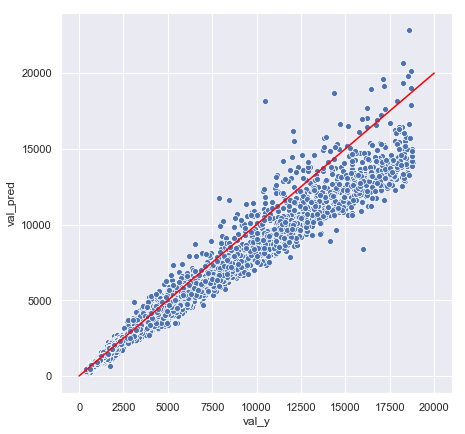

In [145]:
print(df_test_nn.shape[0])
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=df_test_nn, x="val_y", y="val_pred")
plt.plot([0,20000],[0,20000], c="red")
plt.show()

10788


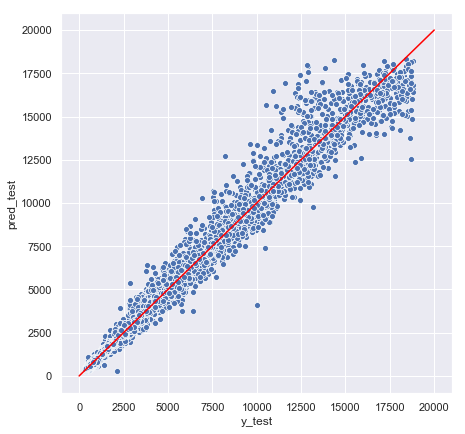

In [41]:
print(df_test_xgb.shape[0])
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=df_test_xgb, x="y_test", y="pred_test")
plt.plot([0,20000],[0,20000], c="red")
plt.show()

## References

- [カテゴリー変数に embedding layer を用いたNeural Net](http://puyokw.hatenablog.com/entry/2016/05/22/090000)
    - Entity Embedding について解説した日本語のブログ
- [Entity Embeddings of Categorical Variables（論文）](https://arxiv.org/abs/1604.06737)
    - arxiv
- [entron/entity-embedding-rossmann（Github）](https://github.com/entron/entity-embedding-rossmann)
    - Github にコードが公開されている
- [Code sharing, 3rd place, category embedding with deep neural network（Kaggle）](https://www.kaggle.com/c/rossmann-store-sales/discussion/17974)
    - Rossmann Store Sales コンペで用いられ、3rd Place に入賞した
- [KerasでEmbedding](http://kento1109.hatenablog.com/entry/2017/12/02/114515)
    - Embedding の動きの確認ができる（ある値の表現力が高まることが確認できる）
- [Embeddingレイヤー（Keras 公式）](https://keras.io/ja/layers/embeddings/)

<p>

- kaggle での利用例
    - [Entity Embedding Neural Net by Joe Eddy](https://www.kaggle.com/aquatic/entity-embedding-neural-net)
    - [Entity Embedding Neural Network Keras [LB 0.748] by David Lobstein](https://www.kaggle.com/astrus/entity-embedding-neural-network-keras-lb-0-748)
    - [Deep learning with Entity Embeddings by DHoa](https://www.kaggle.com/dienhoa/deep-learning-with-entity-embeddings)

---

## XGBoost with Entity Embedding

In [89]:
list_embedding[1:4]

[array([[ 0.2731751 ,  0.09826472, -0.263837  ,  0.20851654],
        [-0.01518973, -0.24255034, -0.31074032,  0.24699862],
        [-0.20864318,  0.09074724, -0.09376038, -0.2206139 ],
        [ 0.3029632 , -0.2536594 ,  0.23882218, -0.18504058],
        [-0.20690957,  0.16070539,  0.28217408,  0.19347858]],
       dtype=float32),
 array([[-0.20212163,  0.16094697,  0.01282644, -0.28060696, -0.16694048,
          0.17291108],
        [-0.2022891 , -0.17555526,  0.1234035 , -0.05428465, -0.15561882,
         -0.05400407],
        [-0.10907964, -0.23934707, -0.05101788,  0.13959429,  0.14706726,
          0.12491578],
        [ 0.12417705,  0.0297751 , -0.12062776, -0.03597434,  0.15626077,
          0.05189863],
        [ 0.2845357 ,  0.06707472, -0.00832104,  0.04032222, -0.1496657 ,
         -0.06003283],
        [ 0.24766149,  0.28434163,  0.07667048, -0.01547976,  0.16380137,
         -0.07593958],
        [ 0.12802653,  0.12346317, -0.17859223,  0.35071543, -0.02935021,
         -

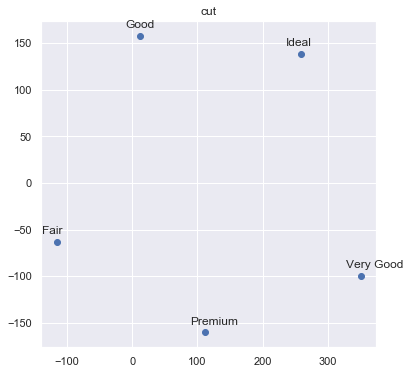

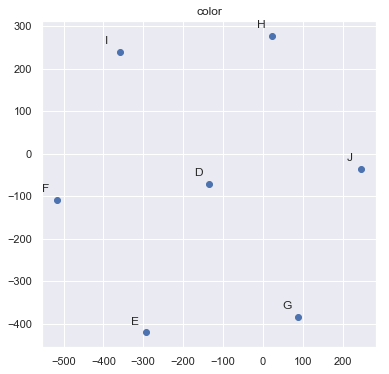

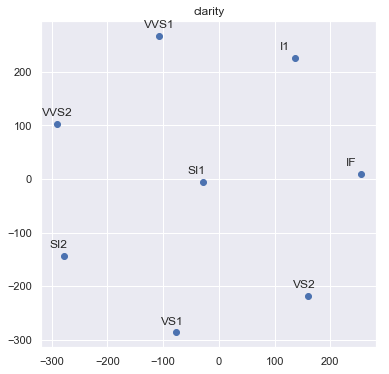

In [99]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

for idx, col in zip(range(3), ["cut", "color", "clarity"]):
    idx += 1
    names = np.unique(diamonds[col])
    X_embedded = TSNE(n_components=2).fit_transform(list_embedding[idx])
    plt.figure(figsize=(6,6))
    plt.scatter(-X_embedded[:, 0], -X_embedded[:, 1])
    plt.title(col)
    for i, txt in enumerate(names):
        plt.annotate(txt, (-X_embedded[i, 0],-X_embedded[i, 1]), xytext = (-15, 8), textcoords = 'offset points')

In [128]:
diamonds = sns.load_dataset("diamonds")

def feature_engineering(data):
    df = pd.DataFrame()
    for i, col in enumerate(data.columns):
        embedded = []
        if type(data[col].iloc[0]) == str:
            le = LabelEncoder()
            data[col] = le.fit_transform(np.array(data[col]))
            embedded = [list_embedding[i][val].tolist() for val in data[col]]
            cols = []
            for j in range(len(embedded[0])):
                cols += ["{}{}".format(col,j+1)]
            print(cols)
            tmp = pd.DataFrame(embedded, columns=cols)
            df = pd.concat([df, tmp], axis=1)
    return data, df


diamonds, df_embedded = feature_engineering(diamonds)
diamonds = pd.concat([diamonds, df_embedded], axis=1).drop(["cut", "color", "clarity"], axis=1)
diamonds.head()

['cut1', 'cut2', 'cut3', 'cut4']
['color1', 'color2', 'color3', 'color4', 'color5', 'color6']
['clarity1', 'clarity2', 'clarity3', 'clarity4', 'clarity5', 'clarity6', 'clarity7']


,carat,depth,table,price,x,y,z,cut1,cut2,cut3,...,color4,color5,color6,clarity1,clarity2,clarity3,clarity4,clarity5,clarity6,clarity7
0,0.23,61.5,55.0,326,3.95,3.98,2.43,-0.208643,0.090747,-0.093760,...,-0.054285,-0.155619,-0.054004,0.079830,0.379283,-0.234436,-0.099445,0.057779,-0.151920,-0.181139
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0.302963,-0.253659,0.238822,...,-0.054285,-0.155619,-0.054004,0.159449,0.112389,0.022668,-0.000960,-0.161277,-0.051924,-0.072603
2,0.23,56.9,65.0,327,4.05,4.07,2.31,-0.015190,-0.242550,-0.310740,...,-0.054285,-0.155619,-0.054004,0.060199,-0.043978,0.234908,0.252990,0.130517,-0.014411,0.095705
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.302963,-0.253659,0.238822,...,-0.015480,0.163801,-0.075940,-0.095972,0.084615,0.196929,-0.174781,-0.029764,0.237299,0.081395
4,0.31,63.3,58.0,335,4.34,4.35,2.75,-0.015190,-0.242550,-0.310740,...,0.350715,-0.029350,-0.442124,0.079830,0.379283,-0.234436,-0.099445,0.057779,-0.151920,-0.181139


In [129]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

params = {
          "objective": "reg:linear",
          "eval_metric": "mae",
          "nthread": 4,
          "learning_rate": 0.05,
          "min_child_weight": 0,
          "max_depth": 8,
          "gamma": 0,
          "subsample":0.9,
          "colsample_bytree": 0.9,
          "reg_lambda": 0,
          "silent": 1,
          "seed": 42
         }

def MAPE(trues, preds):
    return np.mean(np.absolute(trues - preds)/trues)

def modeling_xgb(data, params):
    ## Prepare for Xgboost
    #Split dataset to train and test data: Hold-Out
    X_train, X_test, y_train, y_test = train_test_split(data.drop(["price", "x", "y", "z"], axis=1), data["price"], test_size=0.2, random_state = 42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)
    print("学習データ数: {}, 検証データ数: {}, テストデータ数: {}".format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))
    print("X_train: {}\ny_train:{}".format(X_train.iloc[0], y_train.iloc[0]))
    #Get labels
    feature_names = np.array(X_train.columns)
    #Change data-type to matrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.tolist(), feature_names = feature_names)
    dvalid = xgb.DMatrix(X_valid.values, label=y_valid.tolist(), feature_names = feature_names)
    dtest = xgb.DMatrix(X_test.values, label=y_test.tolist(), feature_names = feature_names)
    
    print("process training..")
    model = xgb.train(params, dtrain, num_boost_round=4000, evals=[(dtrain, 'train'), (dvalid, 'eval')], early_stopping_rounds=100, verbose_eval=100)
    
    print("process evaluation...")
    pred_valid = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    
    MAE_valid = mean_absolute_error(y_valid, pred_valid)
    MAE_test = mean_absolute_error(y_test, pred_test)
    MAPE_valid = MAPE(y_valid, pred_valid)
    MAPE_test = MAPE(y_test, pred_test)
    
    #結果出力用
    df_valid = pd.DataFrame(data = {
        "y_valid": y_valid,
        "pred_valid": pred_valid
    })
    df_test = pd.DataFrame(data = {
        "y_test": y_test,
        "pred_test": pred_test
    })
    
    print("MAE_valid：{}  ".format(round(MAE_valid)) )
    print("MAE_test：{}  ".format(round(MAE_test)) )
    print("MAPE_valid：{}  ".format(round(MAPE_valid,4)) )
    print("MAPE_test：{}  ".format(round(MAPE_test,4)) )
    
    return df_valid, df_test

df_valid_xgb2, df_test_xgb2 = modeling_xgb(diamonds, params)

学習データ数: 34521, 検証データ数: 8631, テストデータ数: 10788
X_train: carat        1.160000
depth       60.800000
table       65.000000
cut1        -0.015190
cut2        -0.242550
cut3        -0.310740
cut4         0.246999
color1      -0.109080
color2      -0.239347
color3      -0.051018
color4       0.139594
color5       0.147067
color6       0.124916
clarity1     0.079830
clarity2     0.379283
clarity3    -0.234436
clarity4    -0.099445
clarity5     0.057779
clarity6    -0.151920
clarity7    -0.181139
Name: 6881, dtype: float64
y_train:4131
process training..
[0]	train-mae:3754.52	eval-mae:3692.51
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[100]	train-mae:598.196	eval-mae:597.901
[200]	train-mae:457.845	eval-mae:461.394
[300]	train-mae:383.125	eval-mae:388.637
[400]	train-mae:333.525	eval-mae:341.324
[500]	train-mae:306.49	eval-mae:316.785
[600]	train-mae:290.689	eval-mae:303.62
[700]	train-mae:279.668

10788


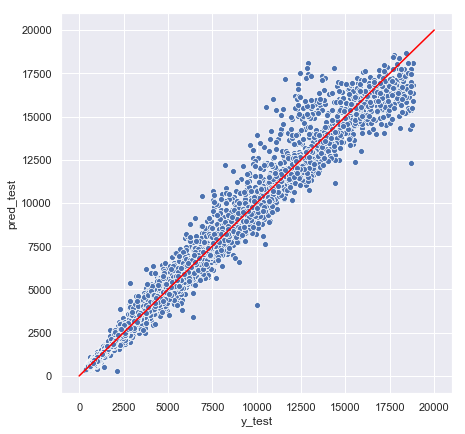

In [130]:
print(df_test_xgb2.shape[0])
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=df_test_xgb2, x="y_test", y="pred_test")
plt.plot([0,20000],[0,20000], c="red")
plt.show()